# Time Series Analysis with LSTM's

This is a quick example demonstrating the use of LSTM's to predict sequences. The idea is that the neuron retains some "memory" of the previous inputs and applies that to the next output. The tuning process tunes the weights that not only control the traditional weights between neurons but also parts that affect how much is remembered.

In this example we reuse the airline dataset and see how well we can predict the next value.

Note that we don't have much data here and we're only trying to predict the next value. Hence, results after the next value could be quite bad.

In [1]:
from sklearn import metrics, datasets, naive_bayes, svm, tree
import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame, concat
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:2849: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


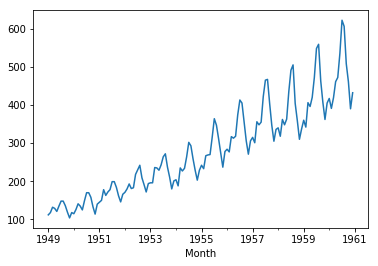

In [2]:
# Load time-series airline data
series = Series.from_csv('data/international-airline-passengers.csv', header=0)
series.plot()
plt.show()

Looking at the data above, we can clearly see an increasing trend in the data. We're going to want to remove that trend to make it easier for the model to predict the data.

First, lets try a simple linear model...

In [3]:
# Fit a linear model to data
x = np.arange(series.index.values.size) # Create a new x axis, since the polyfit can't accept a datetime.
fit = np.polyfit(x, series.values, 1)
fit_fn = np.poly1d(fit)

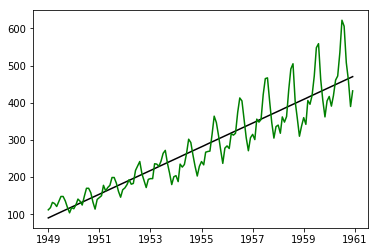

In [4]:
plt.plot(series.index.values, fit_fn(x), 'k-')
plt.plot(series.index.values, series.values, 'g', ms=2)
plt.show()

It fits ok, but I don't think it's quite right. To me it looks a little more exponential. Let's fit an exponential...

In [5]:
res, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  series.values, p0=(100, 0.001))

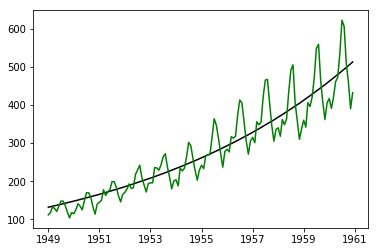

In [6]:
plt.plot(series.index.values, res[0]*np.exp(res[1]*x), 'k-')
plt.plot(series.index.values, series.values, 'g', ms=2)
plt.show()

Still not quite right, but it will do for now.

### Idea: We could calculate the MSE of these curves and compare.

Next, let's remove remove that fit to center everything on zero.

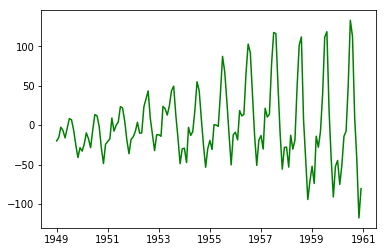

In [7]:
series = series - res[0]*np.exp(res[1]*x)
plt.plot(series.index.values, series.values, 'g', ms=2)
plt.show()

But now look. The variance appears to increase over time. One simple way of negating this is to take an absolute, then fit a linear model. This a poor-mans rms power estimate. We can then divide by that line to create a normalised result.

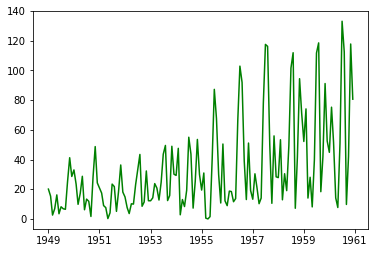

In [8]:
plt.plot(series.index.values, np.abs(series.values), 'g', ms=2)
plt.show()

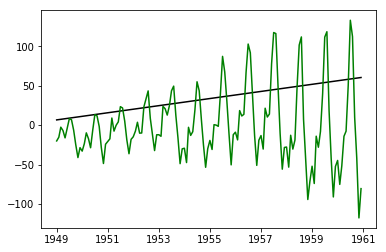

In [9]:
x = np.arange(series.index.values.size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
fit = np.polyfit(x, np.abs(series.values), 1)
fit_fn = np.poly1d(fit)
plt.plot(series.index.values, fit_fn(x), 'k-')
plt.plot(series.index.values, series.values, 'g', ms=2)
plt.show()

In [10]:
series = series / fit_fn(x)

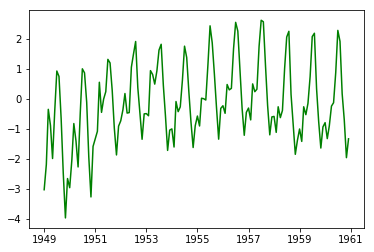

In [11]:
plt.plot(series.index.values, series.values, 'g', ms=2)
plt.show()

Not bad. Now there's just a bit of a bump. I can't tell whether this is just low frequency noise, or if it is another signal. It's good enough for now.

Now we need to scale the data, because LSTMs will blow up if it is out of bounds.

In [12]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(series.values.reshape(-1, 1))

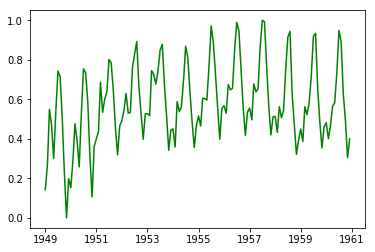

In [13]:
plt.plot(series.index.values, dataset, 'g', ms=2)
plt.show()

There we go.

So, now we get to the interesting part. First we need some code to create a training set from the data.

For example, to set with a history of 1, then we need to create a training set that has one value as the input data and the next value as the label data. We want to do this for every observation we have. I.e.

[1, 2, 4, 8, 16]

Would be turned into:

[ [NaN, 1],
  [1, 2],
  [2, 4],
  [4, 8],
  ...
]

The goal would be to predict the value 2 for the input value 1. The value 4 for the input value 2. Etc.

In [14]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

Next we create and fit an LSTM network. For now we keep it really simple. Just one layer with 3 nodes. We then feed that into a single standard neuron to recreate the output data.

The `predict_lstm` method is a fancy way of reshaping the input data and calling predict.

In [15]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print(i)
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
def predict_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [16]:
supervised = timeseries_to_supervised(dataset, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

And finally, here we go.

In [17]:
# NBVAL_SKIP
error_scores = list()
# fit the model
lstm_model = fit_lstm(train, batch_size=1, nb_epoch=100, neurons=3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Now we have fit the model, we need to do the predictions. LSTMs are interesting because they rely on a history in order to make a prediction. So we need to re-feed all the inputs back through the model in order to get it ready to make a prediction on the test data.

We'll also keep predicting into the future to see what happens.

In [18]:
# NBVAL_SKIP
predictions = list()
for i in range(len(train)):
    X, y = train[i, 0:-1], train[i, -1]
    yhat = predict_lstm(lstm_model, 1, X)
    predictions.append(yhat)
# walk-forward validation on the test data
for i in range(len(test)):
    # make one-step forecast
    X, y = test[i, 0:-1], test[i, -1]
    yhat = predict_lstm(lstm_model, 1, X)
    predictions.append(yhat)
# Continue making predictions
for i in range(10):
    X = np.append(X[1:], yhat)
    yhat = predict_lstm(lstm_model, 1, X)
    predictions.append(yhat)

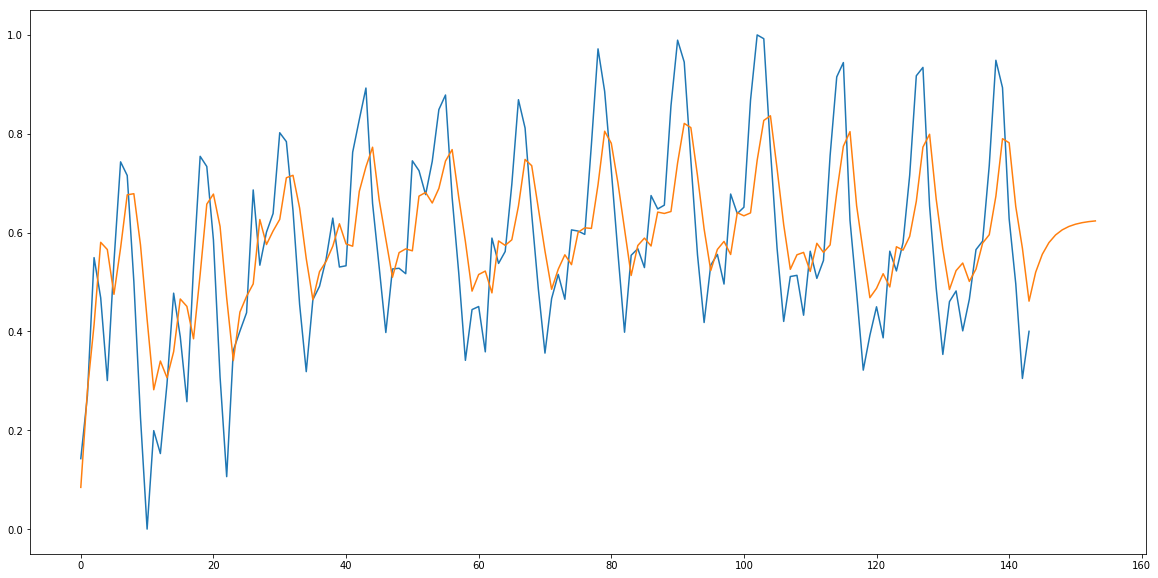

In [19]:
# NBVAL_SKIP
plt.figure(figsize=(20,10))
plt.plot(np.arange(dataset.size), dataset)
plt.plot(np.arange(np.array(predictions).size), np.array(predictions))
plt.show()

## Tasks

- Try to explain what is going on
- Try altering the parameters of the model. More epochs works well. More neurons too. And more history (the `lag` parameter also has an effect)
- Try adding a MSE-like error measurement to the test data. Who can get the best score?